Explicaciones visuales via LIME
===============================

## Introducción

A pesar de su amplia adopción, los modelos de aprendizaje automático - y especialmente aquellos basados en aprendizaje profundo - siguen siendo cajas negras a la hoja de entender como toman las decisiones que toman 1 . Sin embargo, comprender las razones detrás de las predicciones es importante para evaluar la confianza, que es fundamental si uno planea tomar acciones basadas en una predicción o al elegir si implementar un nuevo modelo en el contexto de una organización o proceso de negocio. Esta comprensión también proporciona información sobre el modelo, que se puede utilizar para transformar un modelo o una predicción que no son confiables en uno confiable.

Uno de estos métodos se basan en la idea de perturbaciones. La idea de estos métodos es obstruir o perturbar los datos de entrada con el objetivo de medir como esta perturvación se propaga en el error del modelo. La intuición nos podría confirmar que aquellas áreas de los datos donde el modelo presta atención generarán errores más grandes cuando son perturbadas. Librerías como SHAP y LIME utilizan esta técnica.

### Preparación del ambiente

Intalamos las librerias necesarias

In [1]:
!wget https://raw.githubusercontent.com/santiagxf/M72109/master/docs/vision/tasks/classification/code/cnn_class.txt \
    --quiet --no-clobber
!pip install -r cnn_class.txt --quiet

### Sobre el conjunto de datos de este ejemplo

Origen: https://www.tensorflow.org/datasets/catalog/horses_or_humans

Podemos cargar este conjunto de datos facilmente utilizando `tensorflow-datasets`:

In [45]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds

ds, info = tfds.load('horses_or_humans', split='train', shuffle_files=True, with_info=True)

In [46]:
print("Numero de clases: ", info.features["label"].num_classes)
print("Clases disponibles: ", info.features["label"].names)

Numero de clases:  2
Clases disponibles:  ['horses', 'humans']


Veamos algunos ejemplos:

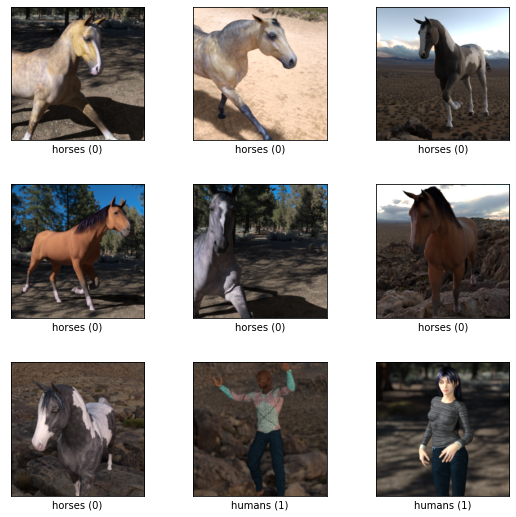

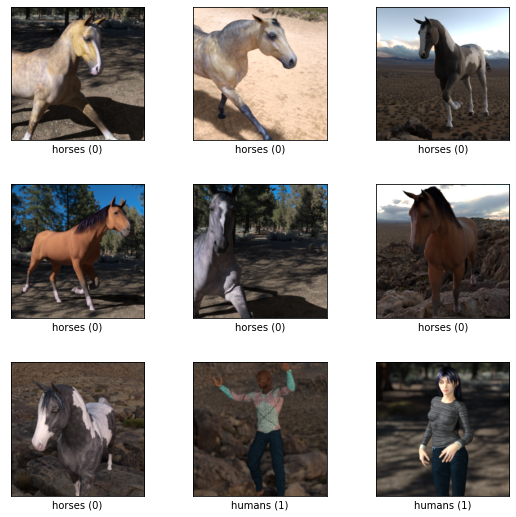

In [47]:
tfds.show_examples(ds, info)

## Construcción de una red neuronal convolucional

### Entendiendo una estructura basada en CNN estandar

Generaremos una red basada en CNNs de 3 bloques concatenados. En este caso la misma constará de:
 - 3 bloques de:
   - 2 capas de CNN
   - 1 capas de Pooling
 - 1 capa de regularización
 - Una red de 2 capas fully-connected

In [48]:
from tensorflow.keras.layers.experimental import preprocessing

In [118]:
def buildModel():
    model = keras.models.Sequential(
      [
         # BLOQUE 1
         keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(300,300,3)),
         keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
         keras.layers.MaxPooling2D((2, 2)), # Me quedo con 1/4

         # BLOQUE 2
         keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
         keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
         keras.layers.MaxPooling2D((2, 2)), # Me quedo con 1/4

         # BLOQUE 3
         keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
         keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
         keras.layers.MaxPooling2D((2, 2)), # Me quedo con 1/4

         # CLASIFICADOR NORMAL
         keras.layers.Flatten(),
         keras.layers.Dropout(0.5),
         keras.layers.Dense(128, activation='relu'),
         keras.layers.Dense(2, activation='softmax')
      ])

    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    
    return model

Instanciamos nuestro modelo y verificamos su arquitectura

In [119]:
model = buildModel()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 300, 300, 32)      896       
                                                                 
 conv2d_19 (Conv2D)          (None, 300, 300, 32)      9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 150, 150, 32)     0         
 2D)                                                             
                                                                 
 conv2d_20 (Conv2D)          (None, 150, 150, 64)      18496     
                                                                 
 conv2d_21 (Conv2D)          (None, 150, 150, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                 

Antes de comenzar el entrenamiento, configuraremos nuestro conjunto de datos para una tarea supervisada. Esto lo hacemos especificando el parametro *as_supervised=True* lo cual nos da la posibilidad de acceder a las anotaciones del conjunto de datos.

In [120]:
(training_set, validation_set) = tfds.load('horses_or_humans', split=['train', 'test'], as_supervised=True)

Configuramos los parametros de entrenamiento:

> Note que utilizamos una función para normalizar la entrada

In [122]:
BATCH_SIZE=64
EPOCHS = 3

normalizer = preprocessing.Rescaling(scale=1./255)

def normalize(x, y):
  return normalizer(x), y

training_set_batch = training_set.map(normalize).batch(batch_size=BATCH_SIZE).cache().repeat()
validation_set_batch = validation_set.map(normalize).batch(batch_size=BATCH_SIZE).cache().repeat()
train_size = info.splits['train'].num_examples
test_size = info.splits['test'].num_examples

Comenzamos el entrenamiento

In [123]:
history = model.fit(training_set_batch, 
                    epochs=EPOCHS,
                    steps_per_epoch=train_size,
                    validation_data=validation_set_batch,
                    validation_steps=test_size)

Epoch 1/3
1027/1027 [==============================] - 808s 786ms/step - loss: 0.0460 - accuracy: 0.9826 - val_loss: 7.9348 - val_accuracy: 0.8242
Epoch 2/3
1027/1027 [==============================] - 810s 788ms/step - loss: 2.0341e-06 - accuracy: 1.0000 - val_loss: 8.7592 - val_accuracy: 0.8242
Epoch 3/3
1027/1027 [==============================] - 812s 790ms/step - loss: 6.1652e-07 - accuracy: 1.0000 - val_loss: 9.5498 - val_accuracy: 0.8320


Guardamos el modelo que acabamos de entrenar

In [127]:
model.save("horses_humans.h5")

In [128]:
!zip horses_humans.zip horses_humans.h5

updating: horses_humans.h5 (deflated 39%)


## Interpretando las predicciones

Instalamos la librería LIME

In [8]:
!pip install lime --quiet

Cargamos el modelo en caso de que no lo hayamos entrenado aqui:

In [129]:
model = tf.keras.models.load_model('horses_humans.h5')

Generamos un explainer

In [96]:
import lime
from lime import lime_image

In [130]:
explainer = lime_image.LimeImageExplainer()

Busquemos una imagen para probar el modelo

In [131]:
!wget https://thehorse.com/wp-content/uploads/2017/09/woman-and-horse-in-pasture-1.jpg

--2021-11-18 22:20:59--  https://thehorse.com/wp-content/uploads/2017/09/woman-and-horse-in-pasture-1.jpg
Resolving thehorse.com (thehorse.com)... 162.159.135.42
Connecting to thehorse.com (thehorse.com)|162.159.135.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79349 (77K) [image/jpeg]
Saving to: ‘woman-and-horse-in-pasture-1.jpg.1’

woman-and-horse-in- 100%[===================>]  77.49K  --.-KB/s    in 0.006s  

2021-11-18 22:20:59 (13.6 MB/s) - ‘woman-and-horse-in-pasture-1.jpg.1’ saved [79349/79349]



Como es constumbre, necesitaremos ajustar la imagen a lo que espera nuestro modelo:

In [132]:
image_shape = (300, 300)

In [133]:
import numpy as np

img = keras.preprocessing.image.load_img('woman-and-horse-in-pasture-1.jpg', target_size=image_shape)
input_img = keras.preprocessing.image.img_to_array(img) / 255.0
input_img = np.expand_dims(input_img, axis=0)

Corremos las explicaciones

In [134]:
explanation = explainer.explain_instance(input_img[0].astype('double'), model.predict, top_labels=2, hide_color=0, num_samples=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

Veamos la imagen original

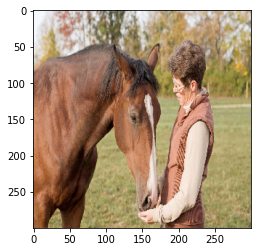

In [135]:
plt.imshow(explanation.image)

Veamos aquellas partes de la imagen que son importantes a la hora de realizar las predicciones

In [136]:
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

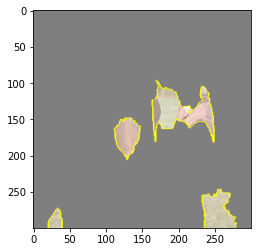

In [137]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

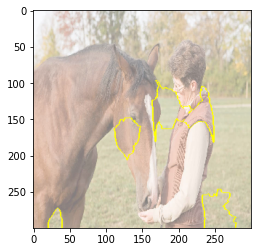

In [138]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

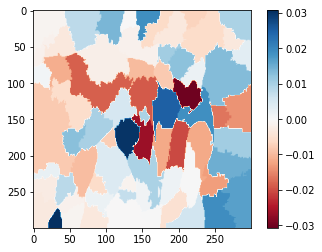

In [139]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()